In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Wed Oct  5 13:08:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
RANDOM_SEED = 123
BATCH_SIZE = 16
NUM_EPOCHS = 12
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
preprocess = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.CIFAR10(root='./data', download=True, transform=preprocess)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
classes = dataset.classes
classes

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
torch.manual_seed(RANDOM_SEED)
train_size = len(dataset)

STEPS_PER_EPOCH = len(dataset) // BATCH_SIZE
STEPS_PER_TEST_EPOCH = len(test) // BATCH_SIZE

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, pin_memory=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

images.shape: torch.Size([16, 3, 224, 224])


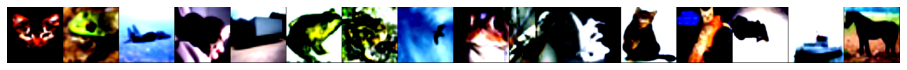

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [7]:
class block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(intermediate_channels,intermediate_channels,kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, img_channels, num_classes):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512*4, num_classes)

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
    
    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride),
                                                nn.BatchNorm2d(out_channels*4))
            
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels*4
        
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))
            
        return nn.Sequential(*layers)
            

In [20]:
model = ResNet(block, [3, 4, 6, 3], 3, 10).to(device)

In [21]:
optimizer = torch.optim.SGD(params=model.parameters(), lr = 0.02, momentum=0.9, nesterov=True)
loss_fn = torch.nn.CrossEntropyLoss()
lmbda = lambda epoch: 0.77
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [22]:
def testing(data_loader):
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return test_loss / total, correct/total*100

In [23]:
avg_test_loss_history = []
avg_test_accuracy_history = []
avg_train_loss_history = []
avg_train_accuracy_history = []

loss_history = []
accuracy_history = []

In [24]:
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch}:")
    for batch_idx, (image, label) in enumerate(train_loader):

        model.train()
        images, labels = image.to(device), label.to(device)
        optimizer.zero_grad()
        
        y_pred = model(images)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item() / BATCH_SIZE)

        total = 0
        correct = 0
        _, predicted = y_pred.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy_history.append(correct / total * 100)

        if (batch_idx+1)%250==0:
            print(f'Batch : {batch_idx+1} | Train_Loss : {sum(loss_history[-250:]) / 250} | Train_Accuracy : {sum(accuracy_history[-250:]) / 250} |', end='\n')
        
    avg_train_loss_history.append(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    avg_train_accuracy_history.append(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)

    scheduler.step()
    print(f'Mean loss for this epoch was {avg_train_loss_history[-1]}')
    print(f'Mean accuracy for this epoch was {avg_train_accuracy_history[-1]}')
    print()

    model.eval()
    with torch.inference_mode():
        test_loss, test_acc = testing(test_loader)
        avg_test_loss_history.append(test_loss)
        avg_test_accuracy_history.append(test_acc)
    print(f'Test Loss : {test_loss} | Test Accuracy : {test_acc}')
    print()

Epoch 0:
Batch : 250 | Train_Loss : 0.19085333988070488 | Train_Accuracy : 15.725 |
Batch : 500 | Train_Loss : 0.13674078658223152 | Train_Accuracy : 20.275 |
Batch : 750 | Train_Loss : 0.13078896966576575 | Train_Accuracy : 23.05 |
Batch : 1000 | Train_Loss : 0.12601300743222238 | Train_Accuracy : 25.025 |
Batch : 1250 | Train_Loss : 0.12093040353059768 | Train_Accuracy : 28.575 |
Batch : 1500 | Train_Loss : 0.11622338989377022 | Train_Accuracy : 30.675 |
Batch : 1750 | Train_Loss : 0.11340266022086143 | Train_Accuracy : 32.375 |
Batch : 2000 | Train_Loss : 0.11260911735892296 | Train_Accuracy : 32.825 |
Batch : 2250 | Train_Loss : 0.1080693232268095 | Train_Accuracy : 35.95 |
Batch : 2500 | Train_Loss : 0.10691183707118035 | Train_Accuracy : 36.575 |
Batch : 2750 | Train_Loss : 0.10347426679730415 | Train_Accuracy : 38.85 |
Batch : 3000 | Train_Loss : 0.10322960689663888 | Train_Accuracy : 38.1 |
Mean loss for this epoch was 0.12162860928416253
Mean accuracy for this epoch was 30.196

KeyboardInterrupt: ignored

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_loss = 0
correct = 0
total = 0
true_labels = []
predictions = []

for batch_idx, (input, target) in enumerate(test_loader):
    inputs, targets = input.to(device), target.to(device)
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

    test_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()

    true_labels.extend(list(target.numpy()))
    predictions.extend(list(predicted.to("cpu").numpy()))

print(f"Final Test Loss {test_loss / total}")
print(f"Final Test Accuracy {correct/total * 100}")

Final Test Loss 0.04804238835573196
Final Test Accuracy 76.5


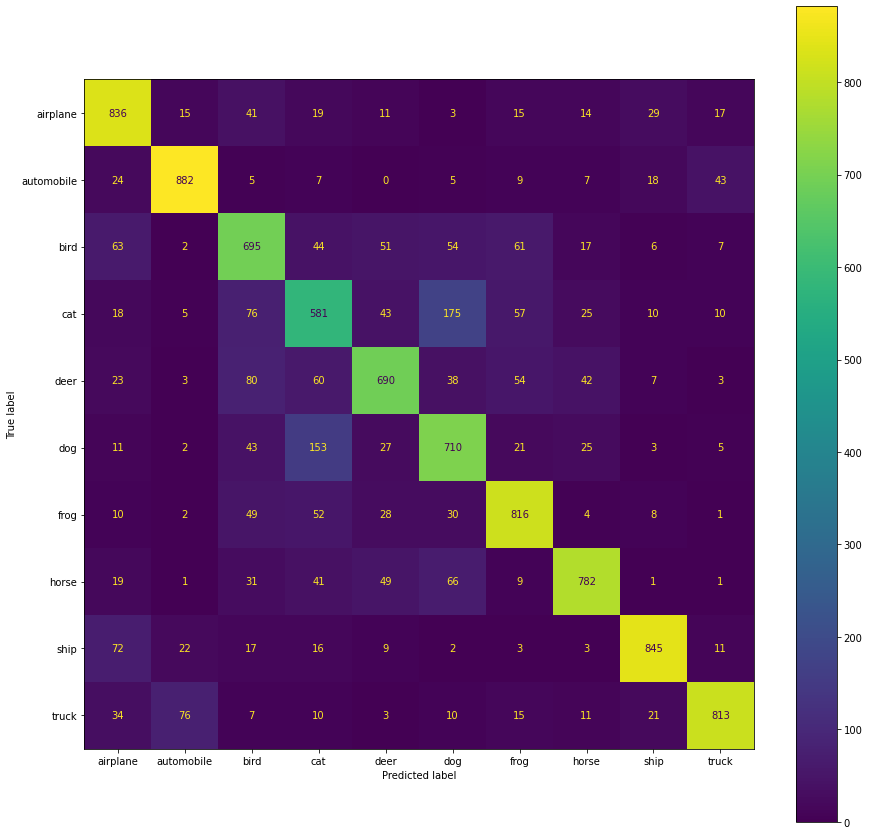

In [61]:
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax)
plt.show()

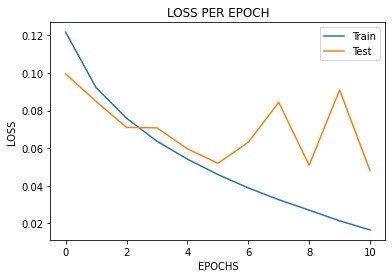

In [64]:
plt.plot(avg_train_loss_history,label = "Train")
plt.plot(avg_test_loss_history , label = "Test")
plt.title('LOSS PER EPOCH')
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.legend()
plt.show()

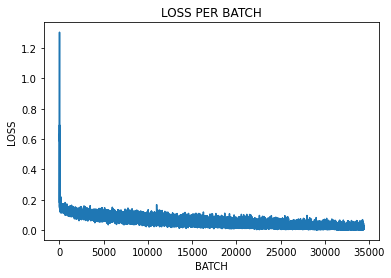

In [65]:
plt.plot(loss_history)
plt.title('LOSS PER BATCH')
plt.xlabel("BATCH")
plt.ylabel("LOSS")
plt.show()

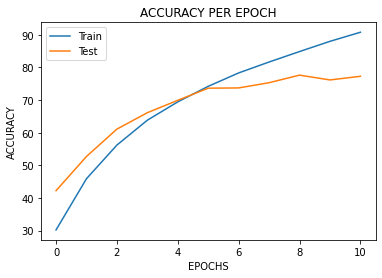

In [66]:
plt.plot(avg_train_accuracy_history , label = "Train")
plt.plot(avg_test_accuracy_history , label = "Test")
plt.title('ACCURACY PER EPOCH')
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.legend()
plt.show()